
Processing: svd3.jpg


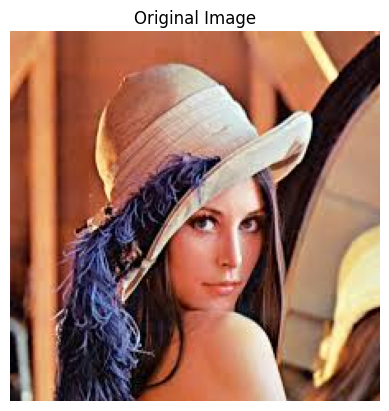

Original shape (H, W, Channels): (225, 225, 3)


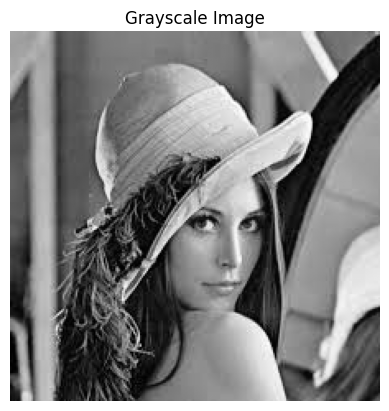

Grayscale shape: (225, 225)
SVD Shapes -> U: (225, 225) S: (225,) Vt: (225, 225)


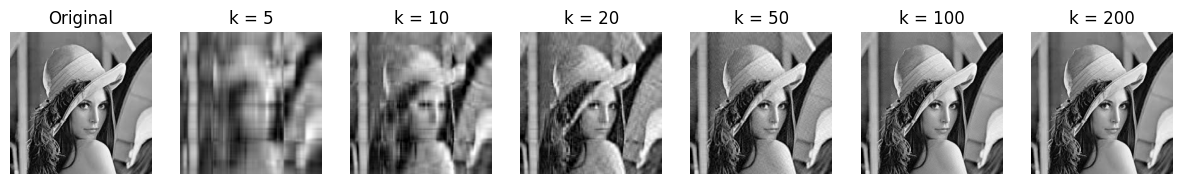

k=5 -> Compression Ratio: 22.45
k=10 -> Compression Ratio: 11.23
k=20 -> Compression Ratio: 5.61
k=50 -> Compression Ratio: 2.25
k=100 -> Compression Ratio: 1.12
k=200 -> Compression Ratio: 0.56

Processing: svd1.png


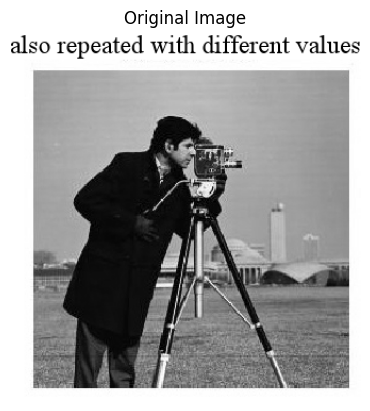

Original shape (H, W, Channels): (348, 330, 4)


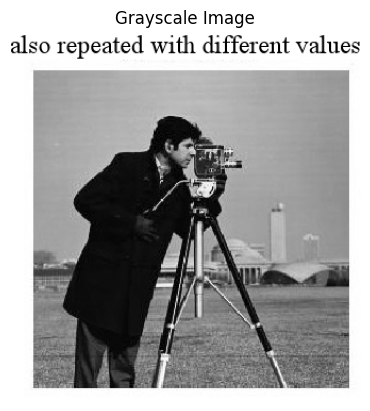

Grayscale shape: (348, 330)
SVD Shapes -> U: (348, 330) S: (330,) Vt: (330, 330)


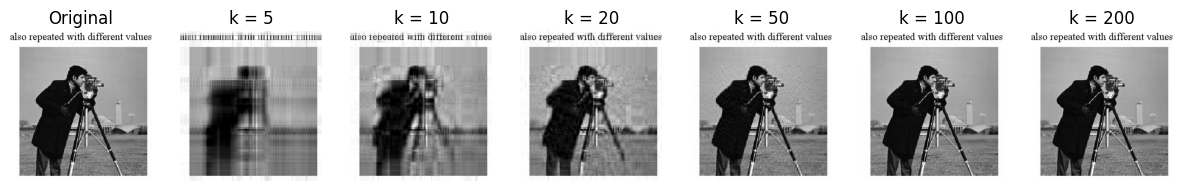

k=5 -> Compression Ratio: 33.83
k=10 -> Compression Ratio: 16.91
k=20 -> Compression Ratio: 8.46
k=50 -> Compression Ratio: 3.38
k=100 -> Compression Ratio: 1.69
k=200 -> Compression Ratio: 0.85

Processing: svd2.ppm


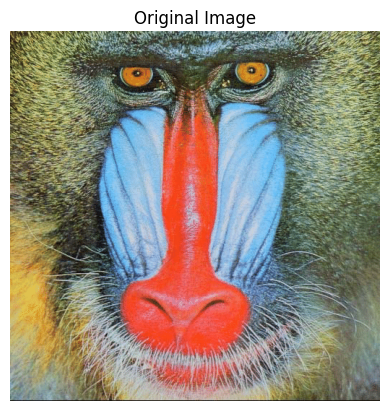

Original shape (H, W, Channels): (512, 512)


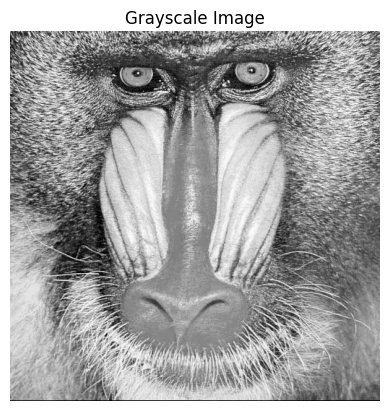

Grayscale shape: (512, 512)
SVD Shapes -> U: (512, 512) S: (512,) Vt: (512, 512)


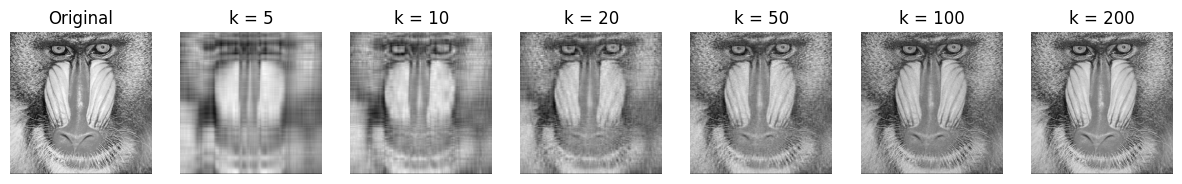

k=5 -> Compression Ratio: 51.15
k=10 -> Compression Ratio: 25.58
k=20 -> Compression Ratio: 12.79
k=50 -> Compression Ratio: 5.12
k=100 -> Compression Ratio: 2.56
k=200 -> Compression Ratio: 1.28


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_files = ["svd3.jpg", "svd1.png", "svd2.ppm"]

# STEP 3: Function to process a single image
def process_image(image_path, k_values):
    print(f"\nProcessing: {image_path}")

    # Load and show original image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    print("Original shape (H, W, Channels):", np.array(img).shape)

    gray_img = img.convert("L")
    plt.imshow(gray_img, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

    A = np.array(gray_img) / 255.0
    #in this we scale evry value ranging from 0-255 to 0-1 due to multiple reaasons
    # prevention of data overflow ,scaling all images ,
    print("Grayscale shape:", A.shape)

    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    print("SVD Shapes -> U:", U.shape, "S:", S.shape, "Vt:", Vt.shape)

    # Function to reconstruct with top k singular values
    def reconstruct_image(U, S, Vt, k):
        S_k = np.diag(S[:k])
        U_k = U[:, :k]
        Vt_k = Vt[:k, :]
        A_k = np.dot(U_k, np.dot(S_k, Vt_k))
        return np.clip(A_k, 0, 1)


    # Show original + reconstructions
    fig, axes = plt.subplots(1, len(k_values)+1, figsize=(15, 5))
    axes[0].imshow(A, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i, k in enumerate(k_values):
        A_k = reconstruct_image(U, S, Vt, k)
        axes[i+1].imshow(A_k, cmap="gray")
        axes[i+1].set_title(f"k = {k}")
        axes[i+1].axis("off")

    plt.show()

    # Compression ratio
    def compression_ratio(m, n, k):
        original = m * n
        compressed = k * (m + n + 1)
        return original / compressed

    m, n = A.shape
    for k in k_values:
        ratio = compression_ratio(m, n, k)
        print(f"k={k} -> Compression Ratio: {ratio:.2f}")

# STEP 4: Run for all images
k_values = [5, 10,20, 50, 100, 200]
for img_file in image_files:
    process_image(img_file, k_values)


Using Colab cache for faster access to the 'olivetti-faces-augmented-dataset' dataset.
Path to dataset files: /kaggle/input/olivetti-faces-augmented-dataset
Loaded faces shape: (2000, 64, 64)
Loaded labels shape: (2000,)
Selected samples: ['face_class_0', 'face_class_1']

===== Class: face_class_0 =====


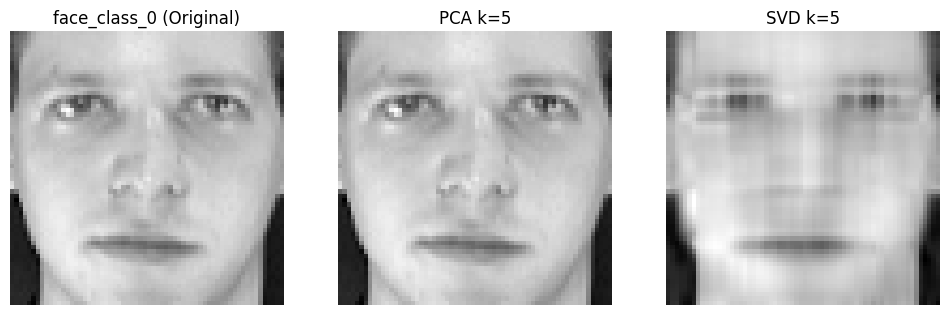

Variance retained with PCA k=5: 1.00


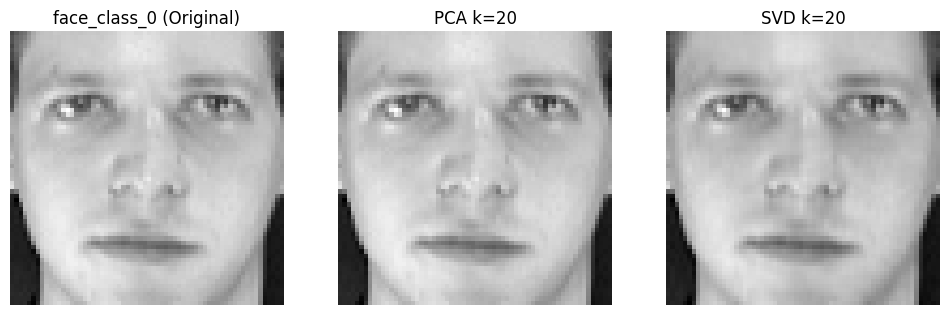

Variance retained with PCA k=20: 1.00


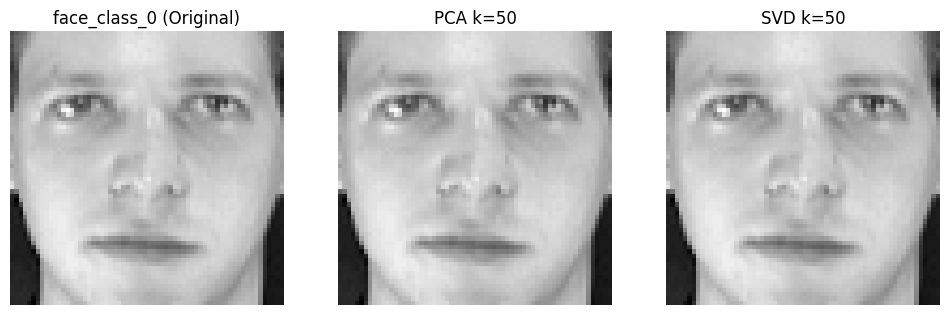

Variance retained with PCA k=50: 1.00


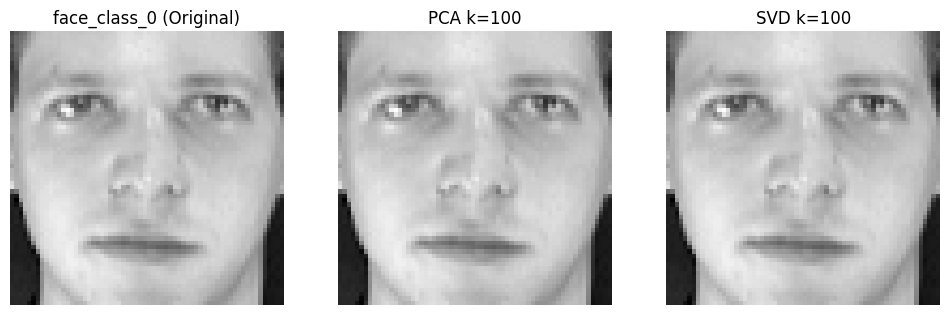

Variance retained with PCA k=100: 1.00

===== Class: face_class_1 =====


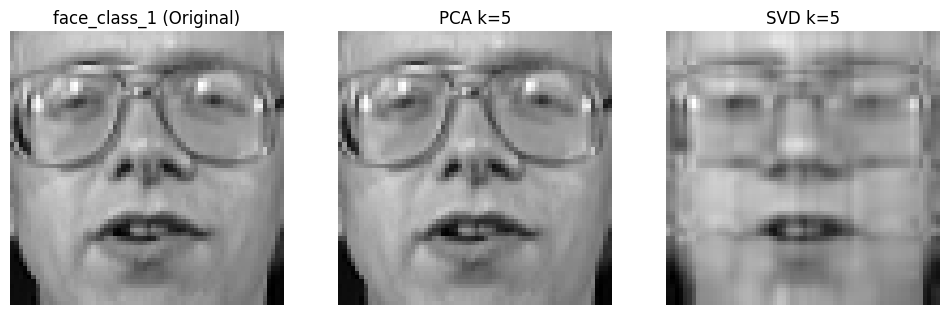

Variance retained with PCA k=5: 1.00


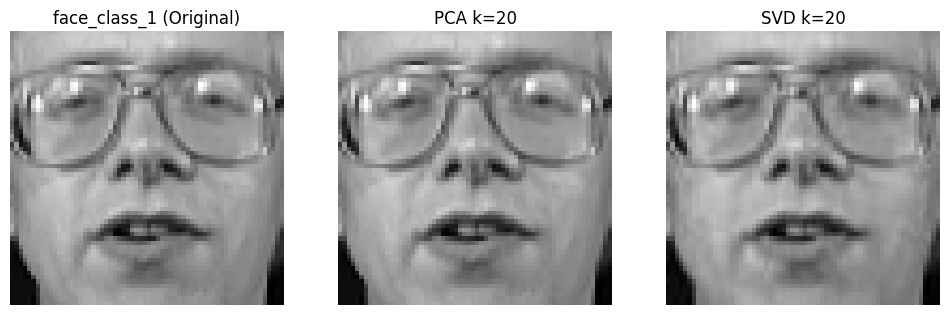

Variance retained with PCA k=20: 1.00


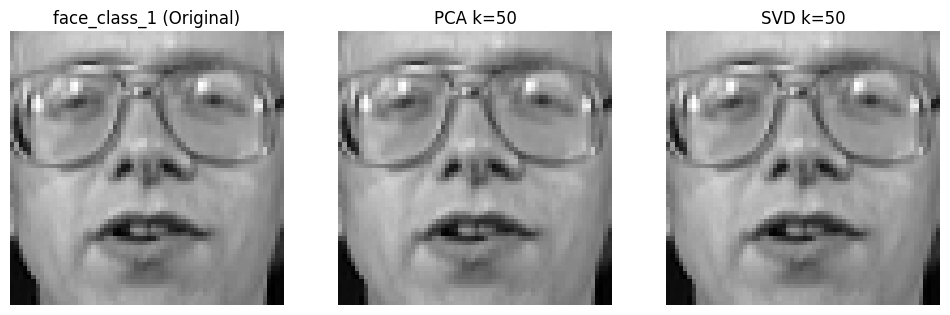

Variance retained with PCA k=50: 1.00


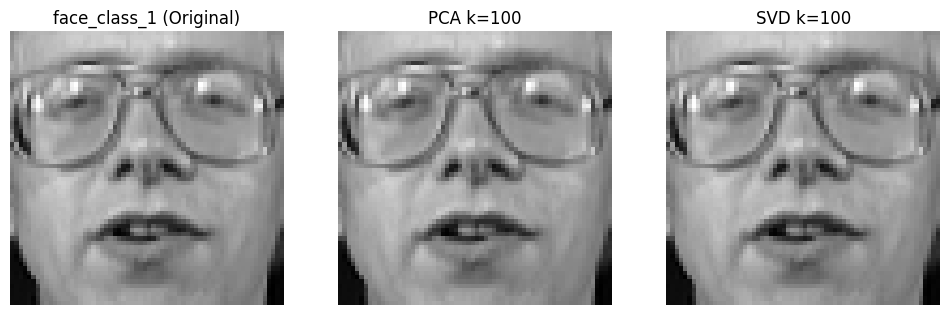

Variance retained with PCA k=100: 1.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

# ---------------------------
# 1. Download & Load dataset
# ---------------------------
path = kagglehub.dataset_download("martininf1n1ty/olivetti-faces-augmented-dataset")
print("Path to dataset files:", path)

# Load .npy files
faces_path = os.path.join(path, "augmented_faces.npy")
labels_path = os.path.join(path, "augmented_labels.npy")

faces = np.load(faces_path)
labels = np.load(labels_path)

print(f"Loaded faces shape: {faces.shape}")  # (N, H, W)
print(f"Loaded labels shape: {labels.shape}")

# ---------------------------
# 2. Select two sample images
# ---------------------------
samples = {}
target_classes = np.unique(labels)

# Pick first 2 unique class images
selected_labels = target_classes[:2]

for i, class_id in enumerate(selected_labels):
    # Get the first image of each class
    idx = np.where(labels == class_id)[0][0]
    samples[f"face_class_{class_id}"] = faces[idx] / 255.0  # Normalize

print("Selected samples:", list(samples.keys()))

# ---------------------------
# 3. PCA preparation
# ---------------------------
X = np.array([img for img in samples.values()])
h, w = X.shape[1:]
X_flat = X.reshape(X.shape[0], -1)

mean_img = np.mean(X_flat, axis=0)
X_centered = X_flat - mean_img

# Covariance and eigendecomposition
cov_matrix = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

def pca_reconstruct(img_flat, k):
    components = eigvecs[:, :k]
    compressed = (img_flat - mean_img) @ components
    reconstructed = (compressed @ components.T) + mean_img
    return reconstructed

# ---------------------------
# 4. SVD reconstruction
# ---------------------------
def svd_reconstruct(img, k):
    U, S, Vt = np.linalg.svd(img, full_matrices=False)
    k = min(k, len(S))
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    return U_k @ S_k @ Vt_k

# ---------------------------
# 5. Compare PCA vs SVD
# ---------------------------
k_values = [5, 20, 50, 100]

for class_name, original in samples.items():
    print(f"\n===== Class: {class_name} =====")
    img_flat = original.reshape(-1)

    for k in k_values:
        recon_pca = pca_reconstruct(img_flat, k).reshape(h, w)
        recon_svd = svd_reconstruct(original, k)

        # Plotting
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(original, cmap="gray")
        plt.title(f"{class_name} (Original)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(np.clip(recon_pca, 0, 1), cmap="gray")
        plt.title(f"PCA k={k}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(np.clip(recon_svd, 0, 1), cmap="gray")
        plt.title(f"SVD k={k}")
        plt.axis("off")

        plt.show()

        explained_variance_ratio = eigvals / np.sum(eigvals)
        var_retained = np.sum(explained_variance_ratio[:k])
        print(f"Variance retained with PCA k={k}: {var_retained:.2f}")


 PCA vs. SVD on Face Data

- **PCA with only 5 components** already keeps the face recognizable → strong evidence that faces live on a **low-dimensional manifold**.

- **SVD with k = 5** looks blurred because singular vectors only capture **energy distribution**, not semantic directions.

- For **k ≈ 20**, both PCA and SVD reconstructions are very close to the original, but PCA still looks slightly smoother because it exploits **dataset-level correlations**.

- **Variance retained** is an excellent quantitative measure:  
  - It rises steeply for small *k*.  
  - Then levels off → a sign of **diminishing returns**.
